# ML-IMC

In [1]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("src/distances.jl")
    include("src/readLJ.jl")
    include("src/ML-IMC.jl");
end

## 1. The first simulation

## 1.1. Input data 

In [2]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

bins, rdfref, histref = readRDF("rdf-mean-p40.dat")

parameters = readinput("LJML-init.in")

model = Dense(length(histref), 1, tanh, bias=true);

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


## 1.2. Running the simulation

In [3]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Total number of steps: $(parameters.steps * nworkers() / 1E6)M")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [4]:
outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 0.4M
Starting at: 2022-03-24T23:09:24.713
      From worker 2:	Acceptance ratio = 0.64446
      From worker 5:	Acceptance ratio = 0.64682
      From worker 4:	Acceptance ratio = 0.64316
      From worker 3:	Acceptance ratio = 0.64426
Stopping at: 2022-03-24T23:10:04.131

Walltime: 39 seconds, 418 milliseconds


In [10]:
histNN = mean([output[1] for output in outputs]);

In [11]:
energies = mean([output[2] for output in outputs]);

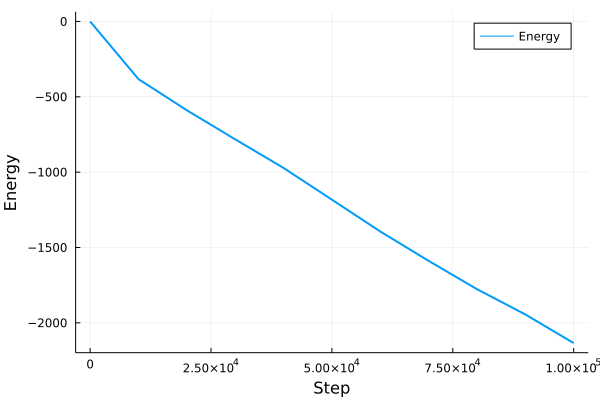

In [15]:
slicing = Int(1E1)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy")
xlabel!("Step")
ylabel!("Energy")

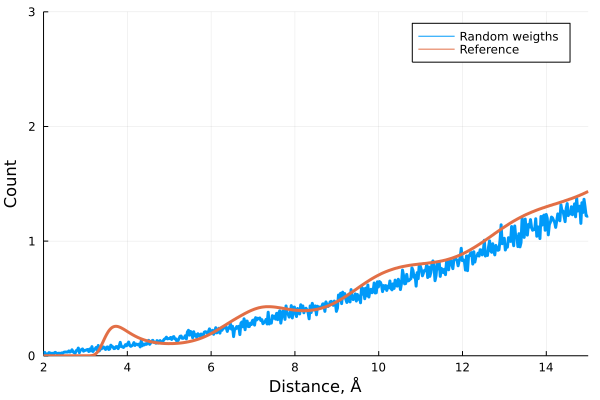

In [13]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Random weigths")
plot!(bins, histref./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

In [18]:
outputs[4][3]

600×600 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0
 ⋮                        

In [19]:
outputs[4][4]

600-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.75810343
 0.6730343
 0.6203475
 0.65475047
 0.60064864
 0.7304195
 0.6933976
 0.64867747
 0.69683754
 0.6557693
 0.6972819
 0.74167466